In [2]:
"""
This is my Prophet code to forecast rainfall in Pittsburgh.
The data has been acquired via NOAA from 2004 to 2014. It has been recorded daily and hourly
within each given day. There are two recording stations given in the data, Murrysville and Pittsburgh.
Further inquiry will be needed to understand the change from former to the latter.

Data Dictionary:
Source : https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/PRECIP_HLY_documentation.pdf
Station - Station ID number
Station - Station name (string)
Date - YYYYMMDD HH:MM
HPCP - Hourly percipitation total (1/100 inches)

References:
C. Sheldon-Hess (https://github.com/ccac-data-analytics/dat-202_sp20/blob/master/weeks10plus/prophet.ipynb)
Prophet Documentation (https://facebook.github.io/prophet/docs/quick_start.html#python-api)
Pandas Documentation (https://pandas.pydata.org/)

"""

'\nThis is my Prophet code to forecast rainfall in Pittsburgh.\nThe data has been acquired via NOAA from 2004 to 2014. It has been recorded daily and hourly\nwithin each given day. There are two recording stations given in the data, Murrysville and Pittsburgh.\nFurther inquiry will be needed to understand the change from former to the latter.\n\nData Dictionary:\nSource : https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/PRECIP_HLY_documentation.pdf\nStation - Station ID number\nStation - Station name (string)\nDate - YYYYMMDD HH:MM\nHPCP - Hourly percipitation total (1/100 inches)\n\nReferences:\nC. Sheldon-Hess (https://github.com/ccac-data-analytics/dat-202_sp20/blob/master/weeks10plus/prophet.ipynb)\nProphet Documentation (https://facebook.github.io/prophet/docs/quick_start.html#python-api)\nPandas Documentation (https://pandas.pydata.org/)\n\n'

In [6]:
## import statements

from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
# conda install did not work; instead used:
# pip install pystan (dependency package)
# pip install fbprophet
from matplotlib import pyplot
%matplotlib inline 
# show plots in line
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [7]:
## read in csv file and print head and print dtype
# using parse_dates function to save a step and format date appropriately
rainfall = pd.read_csv('../data/raw_data/hourly_rainfall_0412.csv', parse_dates=['DATE'])
rainfall.head()
rainfall.tail()
#rainfall.dtypes

,STATION,STATION_NAME,DATE,HPCP
18437,COOP:366993,PITTSBURGH ASOS PA US,2012-12-31 19:00:00,0.01
18438,COOP:366993,PITTSBURGH ASOS PA US,2012-12-31 20:00:00,0.01
18439,COOP:366993,PITTSBURGH ASOS PA US,2012-12-31 21:00:00,0.01
18440,COOP:366993,PITTSBURGH ASOS PA US,2012-12-31 22:00:00,0.01
18441,COOP:366993,PITTSBURGH ASOS PA US,2012-12-31 23:00:00,0.01


In [8]:
## data processing
# Step 1 - Per data dict, '999.99' is the analog to NA, changing to np.nan object, then dropping from dataframe
# Step 2 - Creating new dataframe with only DATE and HPCP as ds and y

## Step 1
# locate all 999.99 HPCP values and replace with NaN numpy objects
rainfall.loc[rainfall['HPCP'] == 999.99] = np.nan
# in new variable drop all indeces (rows) where all values are NaN
rainfall_fixed = rainfall.dropna(axis=0, how='all')
# check work
rainfall_fixed.head()

## Step 2
# Change column names DATE to ds and HPCP to y in new dataframe object
rain_sub = rainfall_fixed.rename(columns={'DATE' : 'ds', 'HPCP' : 'y'})
# Subset the datafram into new object only containing 'ds' and 'y'
rain_input = rain_sub[['ds', 'y']]
# Check work
rain_input.head()
rain_input.tail()

,ds,y
18437,2012-12-31 19:00:00,0.01
18438,2012-12-31 20:00:00,0.01
18439,2012-12-31 21:00:00,0.01
18440,2012-12-31 22:00:00,0.01
18441,2012-12-31 23:00:00,0.01


<AxesSubplot:title={'center':'Hourly Rainfall in Pittsburgh 2004 - 2012'}, xlabel='Years', ylabel='Hundredth of an inch'>

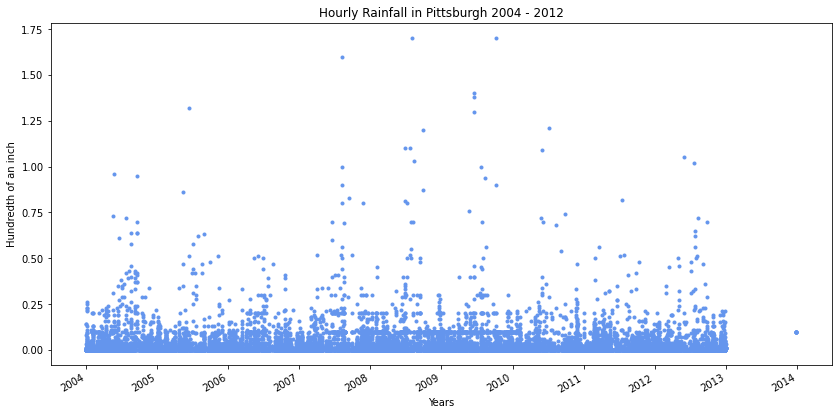

In [9]:
# Plot the data as a scatter plot to take a look and see if there are any trends
rain_input.plot(x='ds', y='y', style='.', title='Hourly Rainfall in Pittsburgh 2004 - 2012', 
                ylabel = 'Hundredth of an inch', xlabel='Years', legend=None, color='cornflowerblue',
               figsize=(14,7))

<AxesSubplot:title={'center':'Hourly Rainfall in Pittsburgh 2004 - 2012'}, xlabel='Years', ylabel='Hundredth of an inch'>

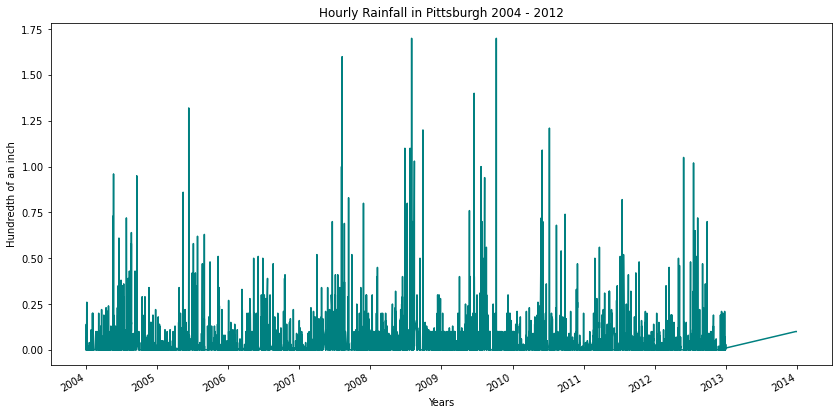

In [10]:
# Plot data again as a barchart for better visualization
rain_input.plot(x='ds', y='y', style='-', title='Hourly Rainfall in Pittsburgh 2004 - 2012', 
                ylabel = 'Hundredth of an inch', xlabel='Years', legend=None, color='Teal', 
                figsize=(14,7))

In [11]:
## Not sure why there's a random 2014 event
## Checking the data shows no matching cases
rain_input.loc[rain_input['ds'] == 2014]

,ds,y


In [12]:
## Creating the Prophet model and fitting it to our dataframe

# Creating the Prophet model object
model = Prophet()
# Fit the model to the data
model.fit(rain_input)

In [52]:
## Import and process the 2013 data
# import 2013 data match previous dataframe and parse dates
rain_test_set = pd.read_csv('../data/raw_data/hourly_rainfall_13.csv', parse_dates=['DATE'])
# check
rain_test_set.head()
# check for 999.99 values to replace with NaN and then strip
rain_test_set.loc[rain_test_set['HPCP'] == 999.99]

# # rename column headers in place
rain_test_set.rename(columns={"DATE" : "ds", "HPCP" : "y"}, inplace=True)
# # drop Station data
rain_test_subset = rain_test_set[['ds', 'y']]
rain_test_subset.tail()

,ds,y
1981,2013-12-31 14:00:00,0.0
1982,2013-12-31 15:00:00,0.0
1983,2013-12-31 16:00:00,0.0
1984,2013-12-31 23:00:00,0.0
1985,2014-01-01 00:00:00,0.0


In [23]:
## Forecast the rain based on the 2013 values
forecast_rain = model.predict(rain_test_subset)

In [24]:
# check out the data (in new cell to avoid rerunning model)
forecast_rain.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01 00:00:00,0.032573,-0.073362,0.105251,0.032573,0.032573,-0.017606,-0.017606,-0.017606,-0.002828,...,0.001328,0.001328,0.001328,-0.016105,-0.016105,-0.016105,0.0,0.0,0.0,0.014967
1,2013-01-01 01:00:00,0.032573,-0.077147,0.103503,0.032573,0.032573,-0.018045,-0.018045,-0.018045,-0.003316,...,0.001396,0.001396,0.001396,-0.016125,-0.016125,-0.016125,0.0,0.0,0.0,0.014528
2,2013-01-01 02:00:00,0.032573,-0.070931,0.102487,0.032573,0.032573,-0.016801,-0.016801,-0.016801,-0.002108,...,0.001452,0.001452,0.001452,-0.016145,-0.016145,-0.016145,0.0,0.0,0.0,0.015772
3,2013-01-01 03:00:00,0.032574,-0.074262,0.103888,0.032574,0.032574,-0.014976,-0.014976,-0.014976,-0.000307,...,0.001496,0.001496,0.001496,-0.016165,-0.016165,-0.016165,0.0,0.0,0.0,0.017597
4,2013-01-01 04:00:00,0.032574,-0.082558,0.106508,0.032574,0.032574,-0.014258,-0.014258,-0.014258,0.000398,...,0.001529,0.001529,0.001529,-0.016185,-0.016185,-0.016185,0.0,0.0,0.0,0.018316


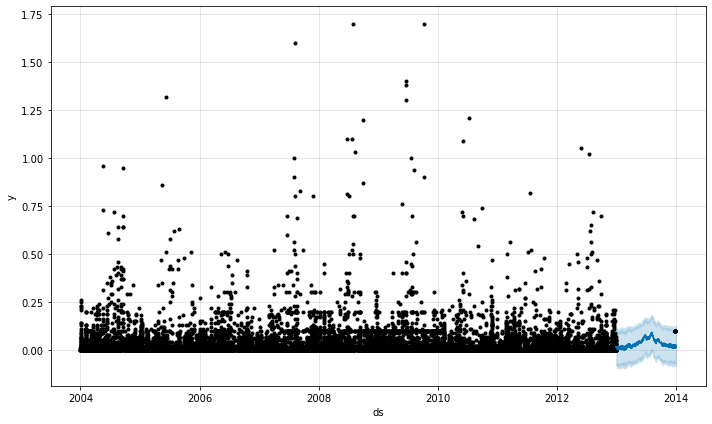

In [27]:
## Plot the forecasted data with the training data
forecast_plot = model.plot(forecast_rain)

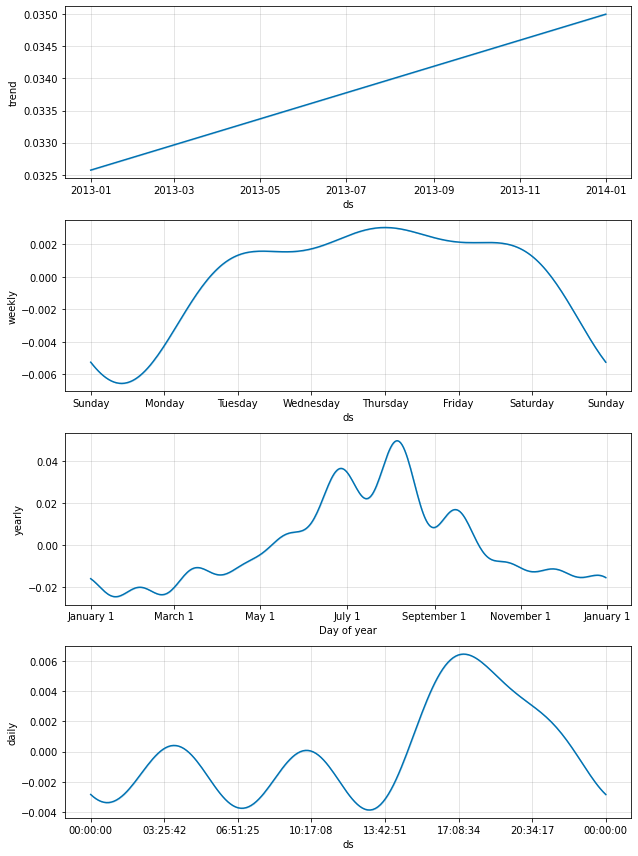

In [30]:
## Plot the components
forecast_comp = model.plot_components(forecast_rain)

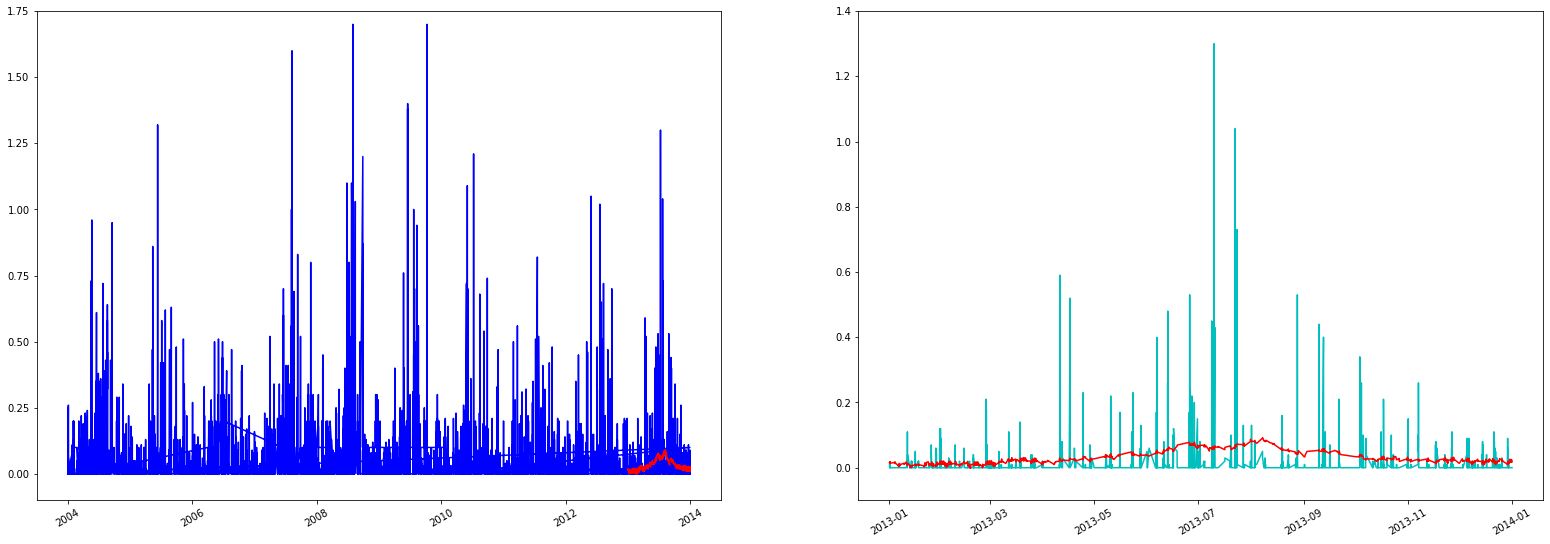

In [54]:
## Graph the predicted and actual values
# (0,1) is the full data set with the predicted 2013 rain
# (0,2) is just 2013 truth and predicted rainfall

graphs = pyplot.figure()
graphs.set_figheight(9)
graphs.set_figwidth(27)

ax0 = graphs.add_subplot(121)
ax0.plot_date(x=rain_input["ds"], y=rain_input["y"], fmt="b-")
ax0.plot_date(x=rain_test_subset["ds"], y=rain_test_subset["y"], fmt="b-")
ax0.plot_date(x=forecast_rain["ds"], y=forecast_rain["yhat"], fmt="r-")
pyplot.ylim(-0.1,1.75)
ax0.xaxis.set_tick_params(rotation=30, labelsize=10)

ax1 = graphs.add_subplot(122)
ax1.plot_date(x=rain_test_subset["ds"], y=rain_test_subset["y"], fmt="c-")
ax1.plot_date(x=forecast_rain["ds"], y=forecast_rain["yhat"], fmt="r-")
pyplot.ylim(-0.1,1.4)
ax1.xaxis.set_tick_params(rotation=30, labelsize=10)

pyplot.show()

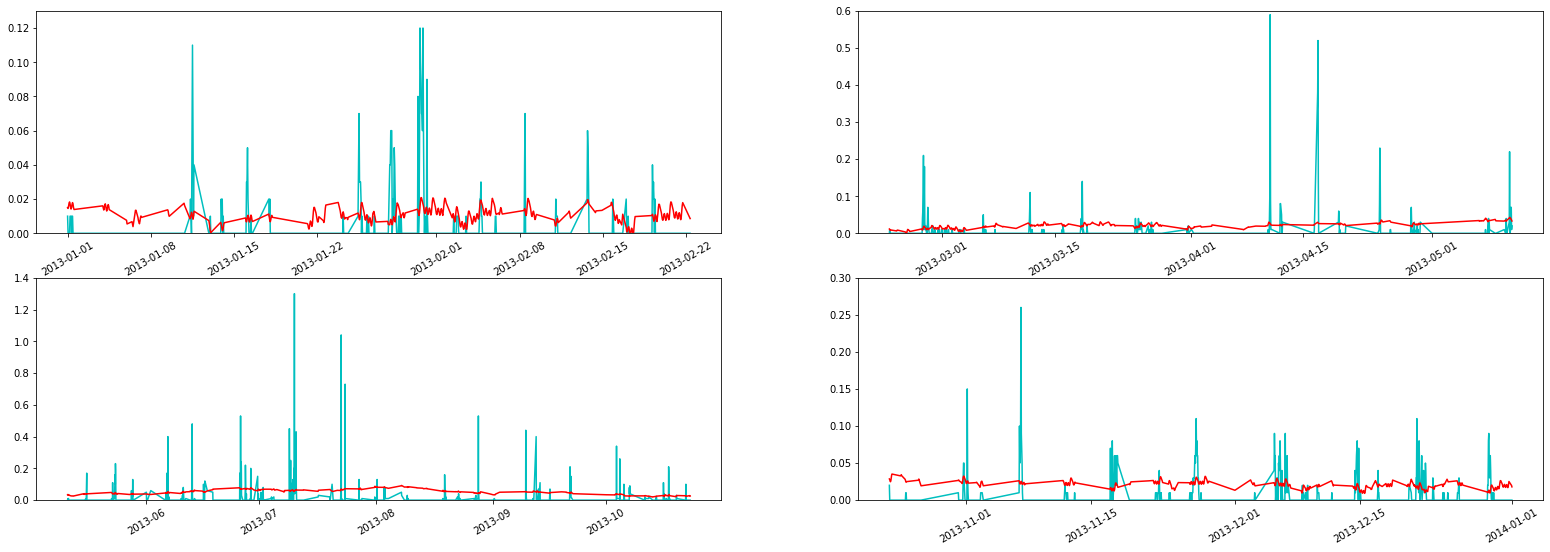

In [61]:
## For more visibility though let's break 2013 into four mostly equal sections so we can see
# how our model did

graphs_2 = pyplot.figure()
graphs_2.set_figheight(9)
graphs_2.set_figwidth(27)

ax2 = graphs_2.add_subplot(221)
ax2.plot_date(x=rain_test_subset["ds"][:496], y=rain_test_subset["y"][:496], fmt="c-")
ax2.plot_date(x=forecast_rain["ds"][:496], y=forecast_rain["yhat"][:496], fmt="r-")
pyplot.ylim(0,0.13)
ax2.xaxis.set_tick_params(rotation=30, labelsize=10)

ax3 = graphs_2.add_subplot(222)
ax3.plot_date(x=rain_test_subset["ds"][497:992], y=rain_test_subset["y"][497:992], fmt="c-")
ax3.plot_date(x=forecast_rain["ds"][497:992], y=forecast_rain["yhat"][497:992], fmt="r-")
pyplot.ylim(0,0.6)
ax3.xaxis.set_tick_params(rotation=30, labelsize=10)

ax4 = graphs_2.add_subplot(223)
ax4.plot_date(x=rain_test_subset["ds"][993:1488], y=rain_test_subset["y"][993:1488], fmt="c-")
ax4.plot_date(x=forecast_rain["ds"][993:1488], y=forecast_rain["yhat"][993:1488], fmt="r-")
pyplot.ylim(0,1.4)
ax4.xaxis.set_tick_params(rotation=30, labelsize=10)

ax5 = graphs_2.add_subplot(224)
ax5.plot_date(x=rain_test_subset["ds"][1489:], y=rain_test_subset["y"][1489:], fmt="c-")
ax5.plot_date(x=forecast_rain["ds"][1489:], y=forecast_rain["yhat"][1489:], fmt="r-")
pyplot.ylim(0,0.3)
ax5.xaxis.set_tick_params(rotation=30, labelsize=10)

pyplot.show()

In [62]:
# Let's calculate the mean squared and mean absolute errors to see how we did metric-wise

mse = mean_squared_error(y_true=rain_test_subset['y'], y_pred=forecast_rain['yhat'])
mae = mean_absolute_error(y_true=rain_test_subset['y'], y_pred=forecast_rain['yhat'])
print(mse ,'\n', mae)

0.003793395002034528 
 0.029479824966492464
